In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from skimage.io import imread
import re
import os
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from radius import *

In [2]:
def auto(path):
    df = pd.read_csv(f'../{path}/Values.csv', encoding='ISO-8859-1')   
    col = ' '.join(path.split(' ')[3:5]).split('/')[0]
    filename = ' '.join(path.split(' ')[3:6]).split('/')[0]
    data = df['Gray_Value']
    dy = np.where([data < np.mean(data)][-1] == True)[-1][-1]
    ddy = np.where([data[:dy] < np.mean(data[:dy])][-1] == True)[-1][-1]
    z = data[:ddy] - savgol_filter(data[:ddy], 100, 1)
    norm = np.std(z)
    n = 30
    for i in range(n-2):
        ind0 = i*ddy//n
        ind1 = (i+1)*ddy//n
        if np.std(z[ind0:ind1]) < norm:
            z[ind0:ind1] = z[ind0:ind1] * norm/np.std(z[ind0:ind1])

    peaks, _ = find_peaks(-1*savgol_filter(z, 9, 3), prominence=np.std(z)/2, width=0.1)

    height = h(peaks)
    cap = spherical_cap_volume(df['Distance_(µm)'][peaks].iloc[-1], height[0])
    dd_vec = df['Distance_(µm)'].iloc[peaks]
    dda_vec = dd_vec.iloc[-1] - dd_vec
    angle_vec = np.arctan2(height, dda_vec)
    angle_deg_vec = np.degrees(angle_vec)
    print(f'{filename} Angle: {np.max(angle_deg_vec):.3f}°') 
    print(f'{filename} Volume: ', cap, 'µL')
    line = '-'
    match filename.split(' ')[-1]:
        case '100_000cst':
            line = '-'
        case '100cst':
            line = '-.'
        case '1000cst':
            line = '--'
    print(col)

    R = dda_vec.iloc[0]
    h1 = height[0]
    thet = np.linspace(0, np.pi/2, 100)
    x = R*np.cos(thet)
    y = h1*np.sin(thet)
    print(R)
    plt.plot(x, y, color=colors[col])

    plt.plot(df['Distance_(µm)'][peaks], height, line, label=filename, color=colors[col])
    plt.xlabel('Distance (µm)')
    plt.ylabel('Height (µm)')
    plt.title('Profile of the droplet')
    plt.legend()
    area = np.trapz(height, dx=1)*2*np.pi*1e-6
    print("area =", area)
    print("cap = ", cap)
    return filename, area, cap

15min 1170C 100_000cst Angle: 3.032°
15min 1170C 100_000cst Volume:  0.10441717425954279 µL
15min 1170C
1246.781
area = 0.02896458666819679
cap =  0.10441717425954279
15min 1150C 100_000cst Angle: 1.976°
15min 1150C 100_000cst Volume:  0.018909352142296568 µL
15min 1150C
801.777
area = 0.0054753471962565
cap =  0.018909352142296568
6min 1150C 100_000cst Angle: 3.304°
6min 1150C 100_000cst Volume:  0.1161092527448943 µL
6min 1150C
1238.149
area = 0.03672917652720812
cap =  0.1161092527448943
15min 1130C 100_000cst Angle: 3.001°
15min 1130C 100_000cst Volume:  0.06894090249797537 µL
15min 1130C
1055.9279999999999
area = 0.02234160669960495
cap =  0.06894090249797537
ref wafer 100_000cst Angle: 7.149°
ref wafer 100_000cst Volume:  0.011374989404063632 µL
ref wafer
438.198
area = 0.021034093789138907
cap =  0.011374989404063632
40min 1130C 100cst Angle: 2.408°
40min 1130C 100cst Volume:  0.06341675988672119 µL
40min 1130C
1150.7820000000002
area = 0.01638716662367604
cap =  0.0634167598867

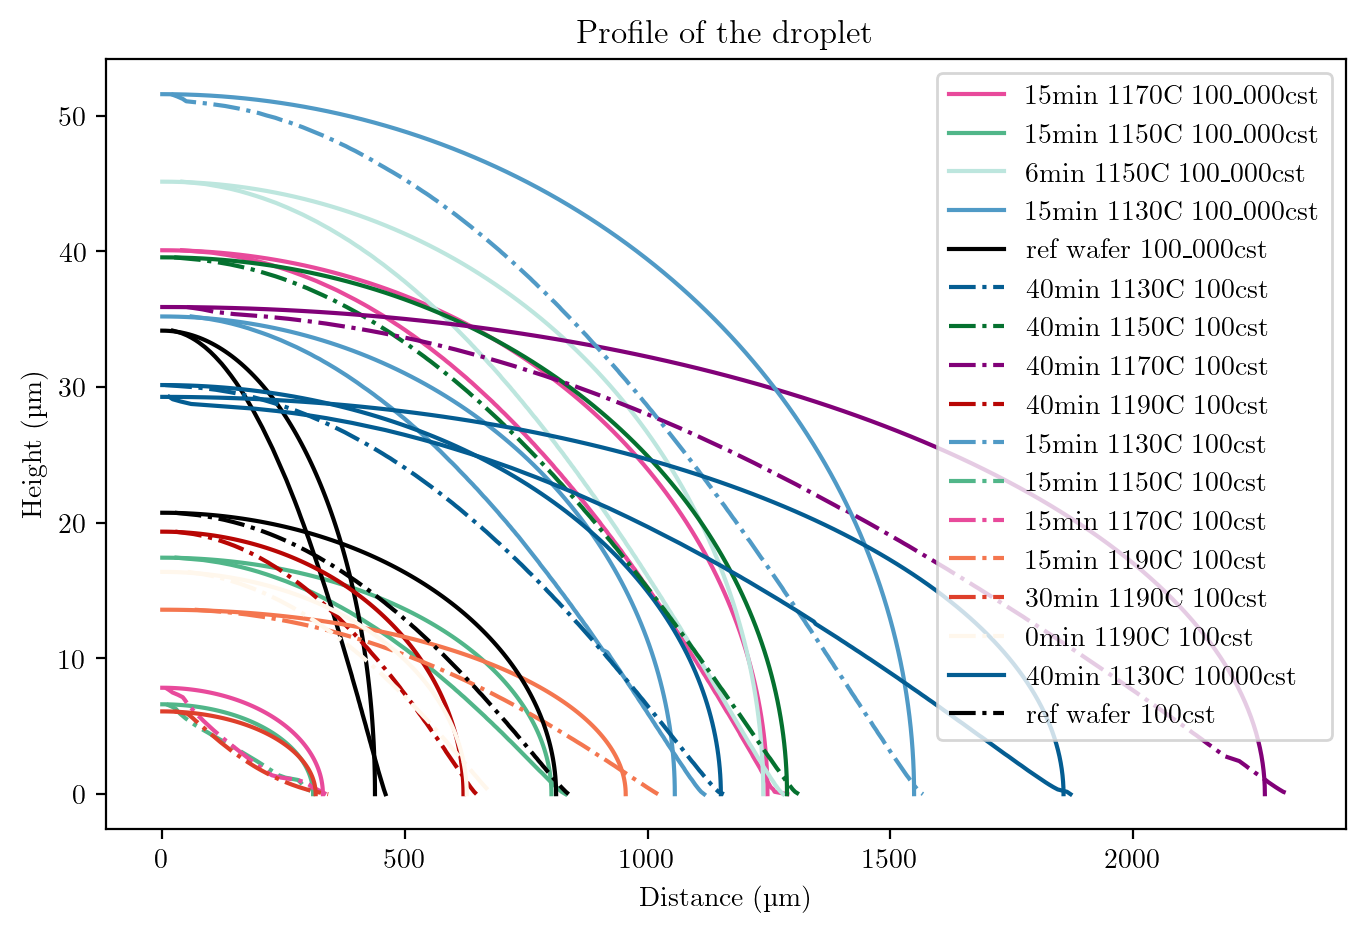

area =  {'15min 1170C 100_000cst': 0.02896458666819679, '15min 1150C 100_000cst': 0.0054753471962565, '6min 1150C 100_000cst': 0.03672917652720812, '15min 1130C 100_000cst': 0.02234160669960495, 'ref wafer 100_000cst': 0.021034093789138907, '40min 1130C 100cst': 0.01638716662367604, '40min 1150C 100cst': 0.02821391656759003, '40min 1170C 100cst': 0.02323518336203401, '40min 1190C 100cst': 0.006746175280507629, '15min 1130C 100cst': 0.04797280199472085, '15min 1150C 100cst': 0.0007906401351394383, '15min 1170C 100cst': 0.0011087578072419412, '15min 1190C 100cst': 0.0033312012342024545, '30min 1190C 100cst': 0.0006707300315414209, '0min 1190C 100cst': 0.004838016782612242, '40min 1130C 10000cst': 0.015453619926714308, 'ref wafer 100cst': 0.007753639164618823}
cap =  {'15min 1170C 100_000cst': 0.10441717425954279, '15min 1150C 100_000cst': 0.018909352142296568, '6min 1150C 100_000cst': 0.1161092527448943, '15min 1130C 100_000cst': 0.06894090249797537, 'ref wafer 100_000cst': 0.01137498940

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
plt.figure(figsize=(8,5), dpi=200)

times = ['50min','40min','30min','15min','8min','6min','3min','0min']
temps = ['1190C','1170C','1150C','1130C']
col = ['PuBu', 'BuGn', 'RdPu', 'OrRd']

colors = {}
for i, t in enumerate(reversed(temps)):
    cmap = plt.get_cmap(col[i])
    num_lines = len(times)
    for j, k in enumerate(times):
        exp = f'{k} {t}'
        color = cmap(1 - j / (num_lines - 1))
        colors[exp] = color
colors['ref wafer'] = 'black'
colors['ref'] = 'black'
area = {}
cap = {}
file, v_area, v_cap = auto('24-06-10 silicon oil 15min 1170C 100_000cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-06-17 silicon oil 15min 1150C 100_000cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-06-20 silicon oil 6min 1150C 100_000cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-06-13 silicon oil 15min 1130C 100_000cst/Position 3')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-06-06 silicon oil ref wafer 100_000cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-07-15 silicone oil 40min 1130C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-07-16 silicone oil 40min 1150C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-07-17 silicone oil 40min 1170C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-07-18 silicone oil 40min 1190C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-07-29 silicone oil 15min 1130C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-08-01 silicone oil 15min 1150C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-08-02 silicone oil 15min 1170C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-08-05 silicone oil 15min 1190C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-08-07 silicone oil 30min 1190C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-07-09 silicone oil 0min 1190C 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-09-16 silicone oil 40min 1130C 10000cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
file, v_area, v_cap = auto('24-09-13 silicone oil ref wafer 100cst')
cap[f'{file}'] = v_cap
area[f'{file}'] = v_area
    #volume theorique
#plt.savefig('figures/profile.pdf', dpi=200)
plt.show()
print("area = ", area)
print("cap = ", cap)
area_vol = area

['15min 1170C 100_000cst', '15min 1150C 100_000cst', '6min 1150C 100_000cst', '15min 1130C 100_000cst', 'ref wafer 100_000cst', '40min 1130C 100cst', '40min 1150C 100cst', '40min 1170C 100cst', '40min 1190C 100cst', '15min 1130C 100cst', '15min 1150C 100cst', '15min 1170C 100cst', '15min 1190C 100cst', '30min 1190C 100cst', '0min 1190C 100cst', '40min 1130C 10000cst', 'ref wafer 100cst']


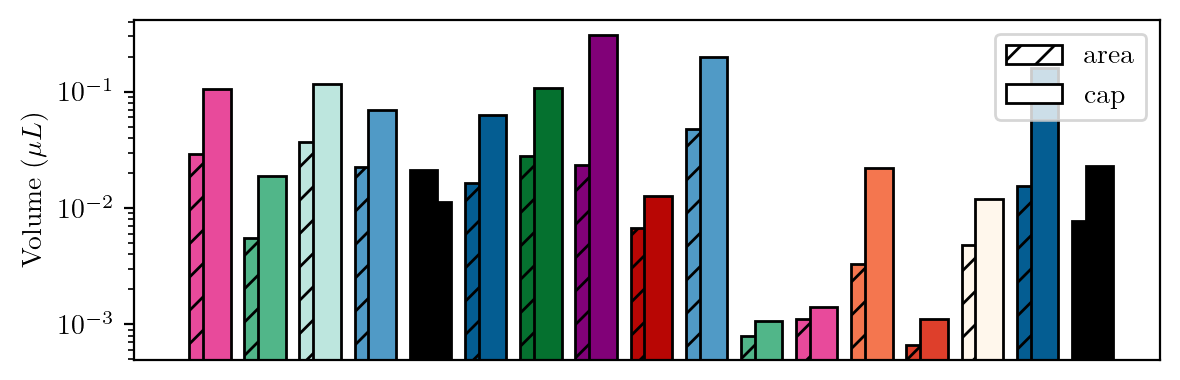

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
fig, ax = plt.subplots(figsize=(6,2), dpi=200)
times = ['50min','40min','30min','15min','8min','6min','3min','0min']
temps = ['1190C','1170C','1150C','1130C']
col = ['PuBu', 'BuGn', 'RdPu', 'OrRd']

colors = {}
for i, t in enumerate(reversed(temps)):
    cmap = plt.get_cmap(col[i])
    num_lines = len(times)
    for j, k in enumerate(times):
        exp = f'{k} {t}'
        color = cmap(1 - j / (num_lines - 1))
        colors[exp] = color
colors['ref wafer'] = 'black'

cap =  {'15min 1170C 100_000cst': 0.10441717425954279, '15min 1150C 100_000cst': 0.018909352142296568, '6min 1150C 100_000cst': 0.1161092527448943, '15min 1130C 100_000cst': 0.06894090249797537, 'ref wafer 100_000cst': 0.011374989404063632, '40min 1130C 100cst': 0.06341675988672119, '40min 1150C 100cst': 0.10692708991573706, '40min 1170C 100cst': 0.30419096505591986, '40min 1190C 100cst': 0.012738990730303984, '15min 1130C 100cst': 0.19908020873337406, '15min 1150C 100cst': 0.0010612319377016112, '15min 1170C 100cst': 0.0014042727042293303, '15min 1190C 100cst': 0.022278980903980915, '30min 1190C 100cst': 0.0011202352480833035, '0min 1190C 100cst': 0.011884132218152847, '40min 1130C 10000cst': 0.16104037916281086, 'ref wafer 100cst': 0.022842319990246}
area =  {'15min 1170C 100_000cst': 0.02896458666819679, '15min 1150C 100_000cst': 0.0054753471962565, '6min 1150C 100_000cst': 0.03672917652720812, '15min 1130C 100_000cst': 0.02234160669960495, 'ref wafer 100_000cst': 0.021034093789138907, '40min 1130C 100cst': 0.01638716662367604, '40min 1150C 100cst': 0.02821391656759003, '40min 1170C 100cst': 0.02323518336203401, '40min 1190C 100cst': 0.006746175280507629, '15min 1130C 100cst': 0.04797280199472085, '15min 1150C 100cst': 0.0007906401351394383, '15min 1170C 100cst': 0.0011087578072419412, '15min 1190C 100cst': 0.0033312012342024545, '30min 1190C 100cst': 0.0006707300315414209, '0min 1190C 100cst': 0.004838016782612242, '40min 1130C 10000cst': 0.015453619926714308, 'ref wafer 100cst': 0.007753639164618823}

grid = range(0,len(cap.keys()))

x_axis = list(cap.keys())
print(x_axis)
i=0
for ar, ca, dat in zip(area.values(), cap.values(), x_axis):
    col = ' '.join(dat.split(' ')[0:2])
    ax.bar(grid[i], ar, width=0.5, edgecolor='black', color=colors[col], hatch='//')
    ax.bar(grid[i]+0.25, ca, width=0.5, edgecolor='black', color=colors[col])
    i+=1
ax.bar(0, 0,color='white', hatch='//', label='area', edgecolor='black') 
ax.bar(0, 0, color='white', label='cap', edgecolor='black') 

#ax.set_xticks(range(len(x_axis)), x_axis)
ax.set_xticks([])
ax.legend()
#ax.set_xlabel('Experiments')
ax.set_ylabel(r'Volume ($\mu L$)')
#ax.set_xticks(x_axis)
#ax.set_xticklabels(x_axis, rotation=45, ha='right')
ax.set_yscale('log')
fig.tight_layout()
#plt.savefig('figures/volume.pdf', dpi=200)
plt.show()

15min 1150C 100_000cst Angle: 1.976°
15min 1150C 100_000cst Volume:  0.018909352142296568 µL
801.777
area = 0.027376735981282492
40min 1150C 100cst Angle: 2.815°
40min 1150C 100cst Volume:  0.10692708991573706 µL
1287.0620000000001
area = 0.14106958283795015
15min 1130C 100cst Angle: 3.002°
15min 1130C 100cst Volume:  0.19908020873337406 µL
1548.886
area = 0.23986400997360421


C:\Users\ad279661\AppData\Local\Temp\ipykernel_25460\716328819.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
C:\Users\ad279661\AppData\Local\Temp\ipykernel_25460\716328819.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
C:\Users\ad279661\AppData\Local\Temp\ipykernel_25460\716328819.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


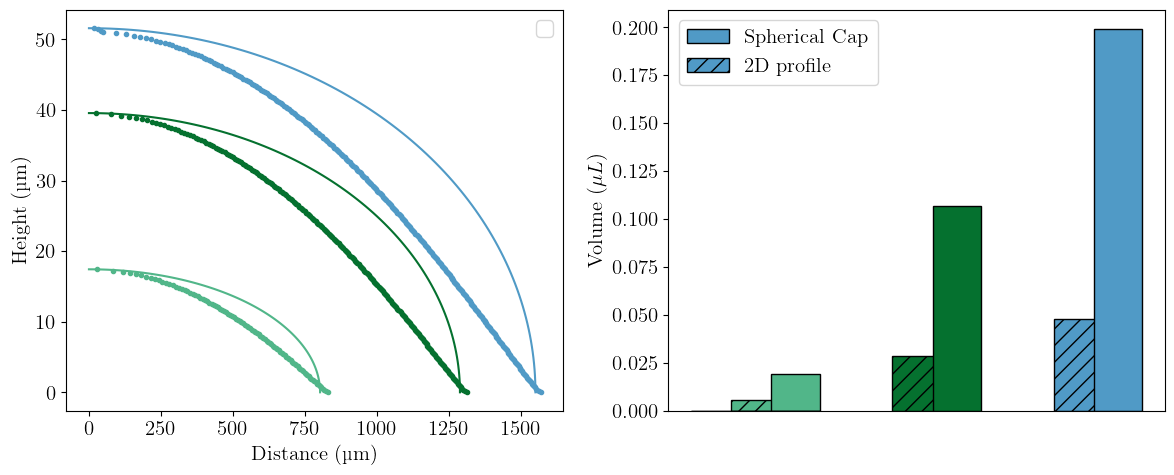

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 15,
})
from scipy.integrate import simpson
from numpy import trapz
def auto(path):
    df = pd.read_csv(f'../{path}/Values.csv', encoding='ISO-8859-1')   
    col = ' '.join(path.split(' ')[3:5]).split('/')[0]
    filename = ' '.join(path.split(' ')[3:6]).split('/')[0]
    data = df['Gray_Value']
    dy = np.where([data < np.mean(data)][-1] == True)[-1][-1]
    ddy = np.where([data[:dy] < np.mean(data[:dy])][-1] == True)[-1][-1]
    z = data[:ddy] - savgol_filter(data[:ddy], 100, 1)
    norm = np.std(z)
    n = 30
    for i in range(n-2):
        ind0 = i*ddy//n
        ind1 = (i+1)*ddy//n
        if np.std(z[ind0:ind1]) < norm:
            z[ind0:ind1] = z[ind0:ind1] * norm/np.std(z[ind0:ind1])

    peaks, _ = find_peaks(-1*savgol_filter(z, 9, 3), prominence=np.std(z)/2, width=0.1)

    height = h(peaks)
    volume = spherical_cap_volume(df['Distance_(µm)'][peaks].iloc[-1], height[0])
    dd_vec = df['Distance_(µm)'].iloc[peaks]
    dda_vec = dd_vec.iloc[-1] - dd_vec
    angle_vec = np.arctan2(height, dda_vec)
    angle_deg_vec = np.degrees(angle_vec)
    print(f'{filename} Angle: {np.max(angle_deg_vec):.3f}°') 
    print(f'{filename} Volume: ', volume, 'µL')
    line = '-'
    match filename.split(' ')[-1]:
        case '100_000cst':
            line = '-'
        case '100cst':
            line = '-.'
        case '1000cst':
            line = '--'
    R = dda_vec.iloc[0]
    h1 = height[0]
    thet = np.linspace(0, np.pi/2, 100)
    x = R*np.cos(thet)
    y = h1*np.sin(thet)
    print(R)
    ax[0].plot(x, y, color=colors[col])
    ax[0].plot(df['Distance_(µm)'][peaks], height, '.', color=colors[col])
    ax[0].set_xlabel('Distance (µm)')
    ax[0].set_ylabel('Height (µm)')
    #ax[0].set_title('Profile of the droplet')
    ax[0].legend()
    #ax[0].set_ylim([0,100])
    area = trapz(height, dx=5)*2*np.pi*1e-6
    print("area =", area)

#V= 1/6​ πh(3r^2 +h^2 )
#6V/(pi h 3r^2) = h^2
#h = sqrt(6V/(pi h 3r^2)) 

fig, ax = plt.subplots(1, 2, figsize=(12,5))

times = ['50min','40min','30min','15min','8min','6min','3min','0min']
temps = ['1190C','1170C','1150C','1130C']
col = ['PuBu', 'BuGn', 'RdPu', 'OrRd']

colors = {}
for i, t in enumerate(reversed(temps)):
    cmap = plt.get_cmap(col[i])
    num_lines = len(times)
    for j, k in enumerate(times):
        exp = f'{k} {t}'
        color = cmap(1 - j / (num_lines - 1))
        colors[exp] = color
colors['ref wafer'] = 'black'
auto('24-06-17 silicon oil 15min 1150C 100_000cst')
auto('24-07-16 silicone oil 40min 1150C 100cst')
auto('24-07-29 silicone oil 15min 1130C 100cst')
data_dict = {
    "15min_1150C_100000cst": {"Volume": 0.018909352142296568, "unit": "µL"},
    "40min_1150C_100cst": {"Volume": 0.10692708991573706, "unit": "µL"},
    "15min_1130C_100cst": {"Volume": 0.19908020873337406, "unit": "µL"},

}
area = (0.0054753471962565, 0.02821391656759003, 0.04797280199472085) # 2D profile
exp = (0.018909352142296568, 0.10692708991573706, 0.19908020873337406) # cap
mark = {
    "100000cst": '.',
    "100cst": "x"
}
volumes = [value['Volume'] for value in data_dict.values()]
x_axis = list(data_dict.keys())
i=0
grid = range(0,3)
width = 0.3   
ind = np.arange(3)    
for vol, dat in zip(volumes, x_axis):
    col = ' '.join(dat.split('_')[0:2])
    visc = dat.split('_')[-1]
    ax[1].bar(grid[i], area[i], width, edgecolor='black', color=colors[col], hatch="//") 
    ax[1].bar(grid[i]+0.25, exp[i], width, edgecolor='black', color=colors[col]) 
    #ax.plot(dat, vol, color='grey', marker=mark[visc])
    i+=1
ax[1].bar(0, 0, color=colors[col], label='Spherical Cap', edgecolor='black') 
ax[1].bar(0, 0, color=colors[col], hatch='//', label='2D profile', edgecolor='black') 

ax[1].set_xticks([])
#ax[1].set_xticks(ind + width / 2, x_axis, rotation=10, ha='right')
ax[1].set_ylabel(r'Volume ($\mu L$)')
ax[1].legend()
fig.tight_layout()
#plt.savefig('figures/volume.pdf', dpi=200)
plt.savefig('../figures/volumes_diff.png', dpi=300, bbox_inches='tight')
plt.show()